###  **Plano de Análise: Macroeconomia vs. E-commerce**
---

#### Expectativas de Mercado **(Focus)**
Fornece as projeções de instituições financeiras para indicadores como **IPCA** e **Selic**. Útil para análise de sentimentos do mercado.

Acesso: Portal de Dados Abertos - **BCB**

#### Sistema Gerenciador de Séries Temporais **(SGS)**
Repositório oficial para dados históricos e realizados (**IPCA real**, **Selic efetiva**, etc.). Fundamental para validação estatística.

Acesso: Interface de Consulta **SGS**

In [132]:
# ajusta path
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [133]:
# importa configurações de paleta de cores
import utils.viz_config

In [134]:
# import das bibliotecas para o EDA
import pandas as pd
from bcb import sgs, Expectativas
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
# formata o pandas para mostrar apenas 4 casas decimais
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [136]:
# função principal para coleta dos dados pelos APIs
def coletar_dados_macro_mensal():
    data_inicio = '2016-01-01'
    data_fim = '2018-12-31'

    # 1. Coleta Selic e IPCA (SGS)
    selic = sgs.get({'selic': 432}, start=data_inicio, end=data_fim)
    ipca_12m = sgs.get({'ipca_12m': 13522}, start=data_inicio, end=data_fim)
    
    # 2. Expectativa Focus
    service = Expectativas()
    exp_12m = service.get_endpoint('ExpectativasMercadoInflacao12Meses')
    df_focus = (
        exp_12m.query()
        .filter(exp_12m.Indicador == 'IPCA', exp_12m.Data >= data_inicio, exp_12m.Data <= data_fim)
        .select(exp_12m.Data, exp_12m.Media)
        .collect()
    )
    
    # Prepara Focus: garante que a data é datetime e define como índice
    df_focus['Data'] = pd.to_datetime(df_focus['Data'])
    ipca_exp = df_focus.groupby('Data')['Media'].mean().to_frame('ipca_exp_12m')

    # 3. Join dos dados diários e preenchimento
    df_macro = selic.join([ipca_exp, ipca_12m]).ffill()
    
    # 4. RESAMPLE: Agrupamento Mensal pela Média
    # 'MS' define o índice como o primeiro dia do mês (Month Start)
    df_mensal = df_macro.resample('MS').mean()
    
    # 5. Cálculo das Taxas Reais (sobre os dados já mensais)
    # Aplicando a Equação de Fisher
    df_mensal['juros_real_ex_ante'] = (((1 + df_mensal['selic']/100) / (1 + df_mensal['ipca_exp_12m']/100)) - 1) * 100
    df_mensal['juros_real_ex_post'] = (((1 + df_mensal['selic']/100) / (1 + df_mensal['ipca_12m']/100)) - 1) * 100
    
    return df_mensal.dropna()

In [137]:
# Executar coleta
df_final = coletar_dados_macro_mensal()

In [138]:
df_final

,selic,ipca_exp_12m,ipca_12m,juros_real_ex_ante,juros_real_ex_post
Date,,,,,
2016-01-01,14.25,7.05,10.71,6.72,3.20
2016-02-01,14.25,6.97,10.36,6.80,3.52
2016-03-01,14.25,6.66,9.39,7.12,4.44
2016-04-01,14.25,6.33,9.28,7.45,4.55
2016-05-01,14.25,6.08,9.32,7.70,4.51
2016-06-01,14.25,6.00,8.84,7.78,4.97
2016-07-01,14.25,5.76,8.74,8.03,5.07
2016-08-01,14.25,5.47,8.97,8.32,4.85
2016-09-01,14.25,5.23,8.48,8.57,5.32


In [139]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2016-01-01 to 2018-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   selic               36 non-null     float64
 1   ipca_exp_12m        36 non-null     float64
 2   ipca_12m            36 non-null     float64
 3   juros_real_ex_ante  36 non-null     float64
 4   juros_real_ex_post  36 non-null     float64
dtypes: float64(5)
memory usage: 1.7 KB


In [140]:
df_final.describe()

,selic,ipca_exp_12m,ipca_12m,juros_real_ex_ante,juros_real_ex_post
count,36.00,36.00,36.00,36.00,36.00
mean,10.31,4.72,5.30,5.32,4.76
std,3.36,0.96,2.69,2.47,1.86
min,6.50,3.67,2.46,1.94,1.86
25%,6.63,4.02,2.86,2.71,3.54
50%,10.17,4.46,4.44,5.56,4.56
75%,14.18,5.07,8.02,7.72,6.57
max,14.25,7.05,10.71,8.70,7.71


In [141]:
# 2. Aplicação do StandardScaler
scaler = StandardScaler()
colunas_para_normalizar = ['selic', 'ipca_exp_12m', 'ipca_12m', 'juros_real_ex_ante', 'juros_real_ex_post'] 

# Criando colunas com sufixo _std
df_final[[c + '_std' for c in colunas_para_normalizar]] = scaler.fit_transform(df_final[colunas_para_normalizar])

In [142]:
df_final.head()

,selic,ipca_exp_12m,ipca_12m,juros_real_ex_ante,juros_real_ex_post,selic_std,ipca_exp_12m_std,ipca_12m_std,juros_real_ex_ante_std,juros_real_ex_post_std
Date,,,,,,,,,,
2016-01-01,14.25,7.05,10.71,6.72,3.20,1.19,2.46,2.04,0.57,-0.86
2016-02-01,14.25,6.97,10.36,6.80,3.52,1.19,2.38,1.91,0.61,-0.68
2016-03-01,14.25,6.66,9.39,7.12,4.44,1.19,2.04,1.55,0.74,-0.17
2016-04-01,14.25,6.33,9.28,7.45,4.55,1.19,1.69,1.50,0.87,-0.12
2016-05-01,14.25,6.08,9.32,7.70,4.51,1.19,1.44,1.52,0.98,-0.14


In [143]:
df_final.filter(like='std').describe()

,selic_std,ipca_exp_12m_std,ipca_12m_std,juros_real_ex_ante_std,juros_real_ex_post_std
count,36.00,36.00,36.00,36.00,36.00
mean,0.00,-0.00,-0.00,-0.00,0.00
std,1.01,1.01,1.01,1.01,1.01
min,-1.15,-1.11,-1.07,-1.39,-1.59
25%,-1.11,-0.74,-0.92,-1.07,-0.67
50%,-0.04,-0.27,-0.33,0.10,-0.11
75%,1.17,0.37,1.03,0.98,0.99
max,1.19,2.46,2.04,1.39,1.61


In [144]:
df_final.to_csv('dados_macro_olist_v1.csv')
print("Arquivo 'dados_macro_olist_v1.csv' gerado com sucesso!")

Arquivo 'dados_macro_olist_v1.csv' gerado com sucesso!


In [145]:
def plotar_matriz_correlação(df_macro, paleta) -> None:
    cmap_custom = LinearSegmentedColormap.from_list("olist", [paleta[2], paleta[0], paleta[4]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_macro.filter(like='_std').corr(), annot=True,
                cmap=cmap_custom)
    plt.title('Matriz de Correlação: Variáveis Macro Normalizadas')
    plt.savefig('matriz_correlacao.png')

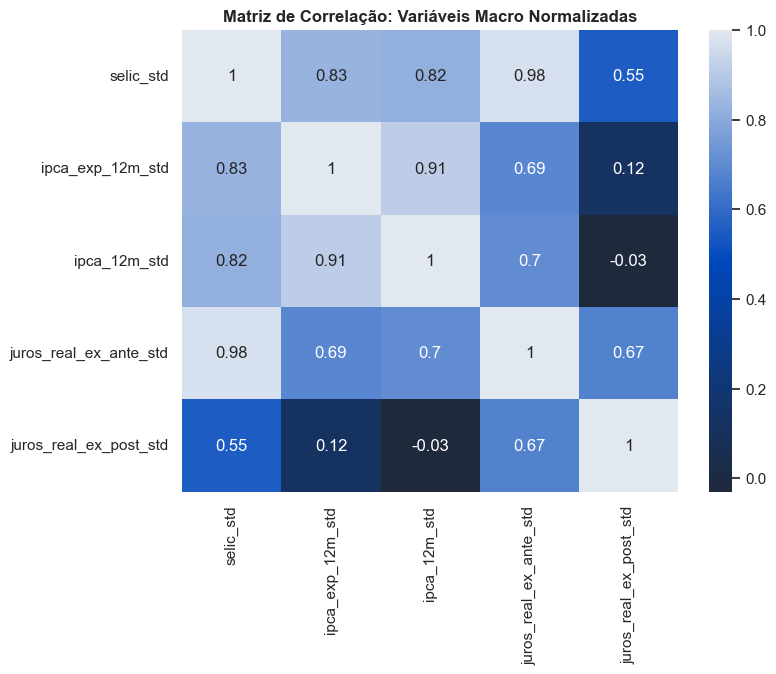

In [146]:
plotar_matriz_correlação(df_final, PALETA_OLIST)

### Síntese da Estrutura Econômica (2016-2018)

A análise de correlação confirma a **robustez** do nosso dataset macroeconômico, evidenciando uma forte convergência entre a política monetária e as expectativas de mercado.

---

###  Principais Insights Estatísticos
* **Alta Interdependência:** Destaque para a correlação de **0.98** entre *Selic* e *Juro Real*, validando a coerência do cenário brasileiro no período.
* **Convergência de Indicadores:** Forte relação entre a Taxa Selic, o Juro Real e as expectativas inflacionárias (IPCA).
* **Validação do Dataset:** Os dados refletem um cenário de transição econômica real, com a Selic caindo de **14,25%** para **6,5%** ao longo do projeto.

###  Impacto no Ecossistema Olist
A estabilidade dessas relações permite utilizar estas variáveis como **preditores confiáveis** para entender:
1. **Volume de Vendas:** Como o custo do crédito influencia o fechamento de novos pedidos.
2. **Comportamento de Compra:** Impacto da inflação e dos juros no *Ticket Médio* e na adesão ao parcelamento.

> **Conclusão:** Esta base macroeconômica serve como fundação sólida para os próximos modelos de previsão de demanda e análise de comportamento do consumidor.

In [147]:
def plotar_cenario_macro(df_macro, paleta):
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(14, 7))
        
        # 1. Selic e IPCA Expectativa
        plt.plot(df_macro.index, df_macro['selic'], label='Selic Nominal (%)', color=paleta[0], linewidth=2.5)
        plt.plot(df_macro.index, df_macro['ipca_exp_12m'], label='Expectativa IPCA (Focus 12m)', color=paleta[3], linestyle='--', linewidth=2)

        # 2. Juro Real Ex-Ante (Sólido - O que o mercado esperava)
        plt.plot(df_macro.index, df_macro['juros_real_ex_ante'], 
        label='Juro Real Ex-Ante (%)', color=paleta[2], linewidth=2.5)

        # 3. Juro Real Ex-Post (Pontilhado - O que aconteceu de fato)
        plt.plot(df_macro.index, df_macro['juros_real_ex_post'], 
        label='Juro Real Ex-Post (%)', color=paleta[2], linestyle=':', linewidth=2, alpha=0.6)
        
        # Títulos e legendas
        plt.title('Cenário Macroeconômico: Decisão (Ex-Ante) vs. Realidade (Ex-Post)', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Taxa (%)', fontsize=12)

        # Destaque para a queda da Selic
        plt.annotate('Início do Ciclo de Queda', 
                xy=(pd.Timestamp('2016-10-19'), 14.25), 
                xytext=(pd.Timestamp('2017-03-01'), 14.5),
                arrowprops=dict(facecolor=paleta[2], shrink=0.05, width=1.5),
                fontsize=10)

        # Shaded area baseada no Ex-Ante (decisão do consumidor)
        plt.fill_between(df_macro.index, df_macro['juros_real_ex_ante'], color=paleta[1], alpha=0.5)

        plt.legend(loc='upper right', frameon=True, fontsize=10)
        plt.tight_layout()
        plt.savefig('cenario_macro.png')
        plt.show()

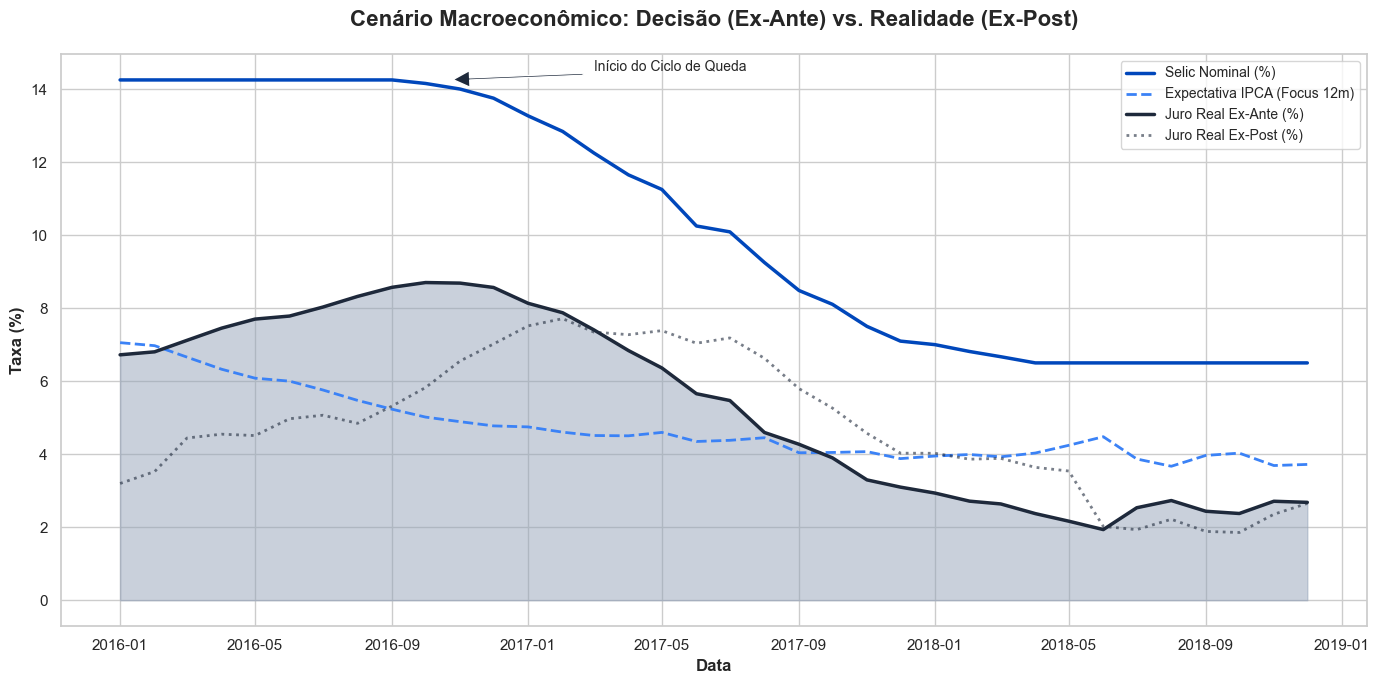

In [148]:
plotar_cenario_macro(df_final, PALETA_OLIST)

### Visualização do Cenário de Transição (2016-2018)

---

O gráfico acima demonstra a **convergência econômica** do período:

1.  **Queda Estrutural:** A Selic Nominal sai de **14,25%** e encerra o período em **6,5%**.
2.  **Juro Real:** O custo real do dinheiro cai significativamente, o que reduz o custo do crédito para o consumidor final da Olist.
3.  **Impacto no E-commerce:** Esse cenário cria um ambiente propício para o aumento do *Ticket Médio*, especialmente em categorias que dependem de parcelamento (eletrônicos e móveis).

In [149]:
def plotar_dispersao_macro(df_macro, paleta):
    plt.figure(figsize=(10, 8))
    
    # Jointplot permite ver a dispersão e a distribuição (histograma) ao mesmo tempo
    g = sns.jointplot(
        data=df_macro, 
        x='ipca_exp_12m', 
        y='selic', 
        kind="reg", # Adiciona a linha de regressão linear
        color=paleta[3],
        scatter_kws={'alpha':0.4}, # Transparência para ver densidade de pontos
        line_kws={'color':paleta[2], 'lw':3} # Linha de tendência em destaque
    )
    
    # Ajustando títulos e eixos
    g.fig.suptitle('Correlação: Expectativa de Inflação vs. Taxa Selic', fontsize=14, fontweight='bold')
    g.fig.subplots_adjust(top=0.92) # Ajusta o título para não cortar
    g.set_axis_labels('Expectativa IPCA (% a.a.)', 'Selic Nominal (% a.a.)', fontsize=12)
    
    plt.savefig('gráfico_de_dispersão.png')
    plt.show()

<Figure size 1000x800 with 0 Axes>

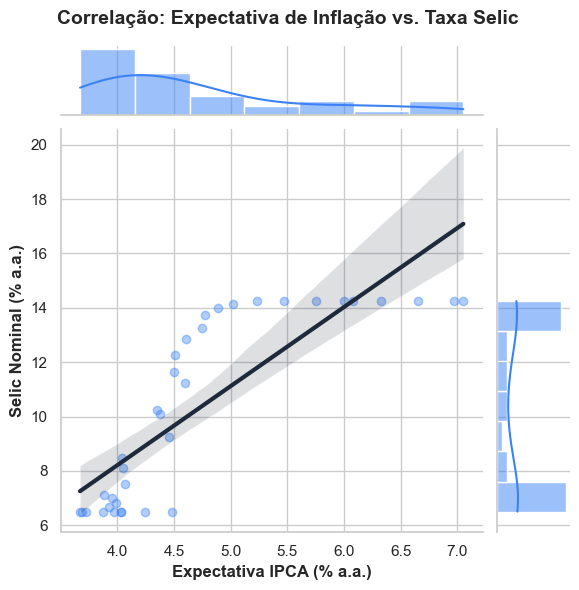

In [150]:
plotar_dispersao_macro(df_final, PALETA_OLIST)

In [151]:
def plotar_distribuicao_juro_real(df_macro, paleta):
    plt.figure(figsize=(12, 6))
    
    # Criando o histograma com a curva de densidade (KDE)
    sns.histplot(df_macro['juros_real_ex_ante'], kde=True, color=paleta[2], bins=20)
    
    # Adicionando linhas de referência (Média e Mediana)
    plt.axvline(df_macro['juros_real_ex_ante'].mean(), color=paleta[0], linestyle='--', label=f"Média: {df_macro['juros_real_ex_ante'].mean():.2f}%")
    plt.axvline(df_macro['juros_real_ex_ante'].median(), color=paleta[3], linestyle=':', label=f"Mediana: {df_macro['juros_real_ex_ante'].median():.2f}%")
    
    plt.title('Distribuição da Taxa de Juros Real Ex-Ante (2016-2018)', fontsize=14, fontweight='bold')
    plt.xlabel('Juro Real (% a.a.)', fontsize=12)
    plt.ylabel('Frequência (Dias)', fontsize=12)
    plt.legend()
    
    plt.show()

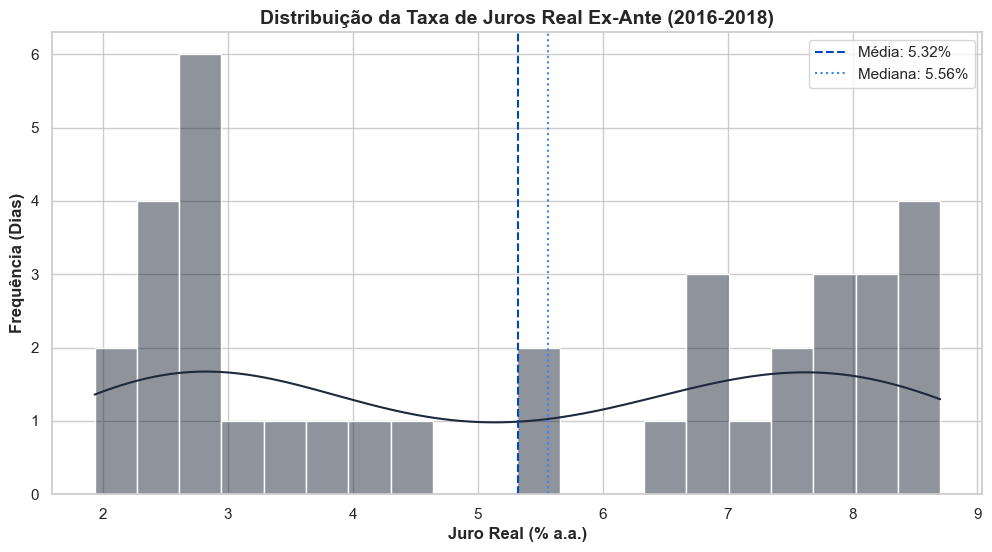

In [152]:
plotar_distribuicao_juro_real(df_final, PALETA_OLIST)

##  Síntese da Estrutura Econômica

---

A análise preliminar das variáveis macro **(SGS e Focus)** estabelece que:

* **Trajetória:** Houve um **choque positivo** de oferta de crédito (queda da Selic).
* **Aderência:** A autoridade monetária seguiu as expectativas do mercado (Linha de Regressão).
* **Custo Médio:** O Juro Real médio enfrentado pelo ecossistema Olist foi de **'5.32%'** (Média da Distribuição).
